**Data : Download examples of spam and ham from *Apache SpamAssassin's public datasets.*** https://spamassassin.apache.org/old/publiccorpus/

In [1]:
from pathlib import Path
import tarfile
import urllib.request

def fetch_spam_data():
    spam_root = "http://spamassassin.apache.org/old/publiccorpus/"
    ham_url = spam_root + "20030228_easy_ham.tar.bz2"
    spam_url = spam_root + "20030228_spam.tar.bz2"
    
    spam_path = Path() / "datasets" / "spam"
    spam_path.mkdir(parents=True, exist_ok=True)
    for dir_name, tar_name, url in (("easy_ham", "ham", ham_url), ("spam", "spam", spam_url)):
        if not (spam_path / dir_name).is_dir():
            path = (spam_path / tar_name).with_suffix(".tar.bz2")
            print("Downloading", path)
            urllib.request.urlretrieve(url, path)
            tar_bz2_file = tarfile.open(path)
            tar_bz2_file.extractall(path=spam_path)
            tar_bz2_file.close()
    return [spam_path / dir_name for dir_name in ("easy_ham", "spam")]

In [2]:
ham_dir, spam_dir = fetch_spam_data()

In [3]:
ham_filenames = [f for f in sorted(ham_dir.iterdir()) if len(f.name) > 20]
spam_filenames = [f for f in sorted(spam_dir.iterdir()) if len(f.name) > 20]

In [4]:
len(ham_filenames)

2500

In [5]:
len(spam_filenames)

500

In [6]:
import email
import email.policy

def load_email(filepath):
    with open(filepath, "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [7]:
ham_emails = [load_email(filepath) for filepath in ham_filenames]
spam_emails = [load_email(filepath) for filepath in spam_filenames]

example of **ham**

In [8]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


example of **spam**

In [9]:
print(spam_emails[1].get_content().strip())

1) Fight The Risk of Cancer!
http://www.adclick.ws/p.cfm?o=315&s=pk007

2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days
http://www.adclick.ws/p.cfm?o=249&s=pk007

3) Get the Child Support You Deserve - Free Legal Advice
http://www.adclick.ws/p.cfm?o=245&s=pk002

4) Join the Web's Fastest Growing Singles Community
http://www.adclick.ws/p.cfm?o=259&s=pk007

5) Start Your Private Photo Album Online!
http://www.adclick.ws/p.cfm?o=283&s=pk007

Have a Wonderful Day,
Offer Manager
PrizeMama













If you wish to leave this list please use the link below.
http://www.qves.com/trim/?ilug@linux.ie%7C17%7C114258


-- 
Irish Linux Users' Group: ilug@linux.ie
http://www.linux.ie/mailman/listinfo/ilug for (un)subscription information.
List maintainer: listmaster@linux.ie


Some emails are actually multipart, with images and attachments (which can have their own attachments). Let's look at the various types of structures we have:

In [10]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        multipart = ", ".join([get_email_structure(sub_email)
                               for sub_email in payload])
        return f"multipart({multipart})"
    else:
        return email.get_content_type()

In [11]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [12]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [13]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

It seems that the ham emails are more often plain text, while spam has quite a lot of HTML. Moreover, quite a few ham emails are signed using PGP, while no spam is. In short, it seems that the email structure is useful information to have.

In [14]:
# Take a look at the email headers
for header, value in spam_emails[0].items():
    print(header, ":", value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

In [15]:
spam_emails[0]["Subject"]

'Life Insurance - Why Pay More?'

In [16]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))
# y is a NumPy array representing the labels, where 0 corresponds to ham emails and 1 corresponds to spam emails.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

## Convert HTML to plain text

In [17]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

In [18]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

In [19]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

## Convert email to plain text 

In [20]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except:  # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [21]:
print(email_to_text(sample_html_spam)[:100], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


We will remove morphological affixes from words, leaving only the word stem by adding some stemming (using Natural Language Toolkit (NLTK))

In [22]:
import nltk

stemmer = nltk.PorterStemmer()
# For examples
for word in ("Calculation", "Calculated", "Calculate", "Calculating", "Calculator",
             "Calculates"):
    print(word, "=>", stemmer.stem(word))

Calculation => calcul
Calculated => calcul
Calculate => calcul
Calculating => calcul
Calculator => calcul
Calculates => calcul


We will also replace URLs.

In [23]:
import urlextract

url_extractor = urlextract.URLExtract()
# For examples
some_text = "CS50 - Lecture 7 - SQL on youtube.com: https://www.youtube.com/watch?v=1RCMYG8RUSE&t=3418s"
print(url_extractor.find_urls(some_text))

['youtube.com', 'https://www.youtube.com/watch?v=1RCMYG8RUSE&t=3418s']


# Data Preparation

Put all this together into a transformer that we will use to convert **emails** to **word counters**. Note that we split sentences into words using Python's `split()` method, which uses whitespaces for word boundaries.

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True,
                remove_punctuation=True, replace_urls=True,
                replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

In [25]:
# Examples
X_example = X_train[:3]
X_example_wordcounts = EmailToWordCounterTransformer().fit_transform(X_example)
X_example_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'url': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 'remsburg': 1, 'letter': 1, 'william': 1, 'short': 1, 'again': 1, 'becom

Next we need to convert the **WordCounter** to the **Vector**. For this, we will build another transformer whose `fit()` method will build the vocabulary (an ordered list of the most common words) and whose `transform()` method will use the vocabulary to convert word counts to vectors. The output is a sparse matrix.

In [26]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000): # We set the default vocabulary_size is 1000
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        # Iteration over each document's word counts, updating a Counter object to keep track of the 
        # total count of each word across all documents. Then, it selects the most common words up to vocabulary_size
        # For example, vocabulary_size=10 so we choose the top 10 most common words and then assigns an index to each word
        # Stores the vocabulary in the vocabulary_ attribute of the transformer.
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += count
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1
                            for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)),
                          shape=(len(X), self.vocabulary_size + 1))

In [27]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_example_vectors = vocab_transformer.fit_transform(X_example_wordcounts)
X_example_vectors

<3x11 sparse matrix of type '<class 'numpy.intc'>'
	with 20 stored elements in Compressed Sparse Row format>

In [28]:
X_example_vectors.toarray()

array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [99, 11,  9,  8,  3,  1,  3,  1,  3,  2,  3],
       [67,  0,  1,  2,  3,  4,  1,  2,  0,  1,  0]], dtype=int32)

**Explain about the example :**
- In the second email (second row) : the 99 in the second row, first column, means that the second email contains 99 words that are not part of the vocabulary. The 11 next to it means that the first word in the vocabulary is present 11 times in this email. The 9 next to it means that the second word is present 9 times, and so on. You can look at the vocabulary to know which words we are talking about. The first word is "the", the second word is "of", etc.
- In the first email : the value 6 means that the first email contains 6 words that are not part of the vocabulary, i.e, the words : {chuck, murcko, wrote, stuff, yawn, r} are not in the top 10 most-common vocabulary

And here is the top-10 most-common words in the example vocabulary

In [29]:
vocab_transformer.vocabulary_

{'the': 1,
 'of': 2,
 'and': 3,
 'to': 4,
 'url': 5,
 'all': 6,
 'in': 7,
 'christian': 8,
 'on': 9,
 'by': 10}

## Transformation Pipelines

In [30]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [31]:
X_train_transformed

<2400x1001 sparse matrix of type '<class 'numpy.intc'>'
	with 187908 stored elements in Compressed Sparse Row format>

In [32]:
X_train_transformed[:10].toarray()

array([[ 3,  0,  0, ...,  0,  0,  0],
       [41,  0, 11, ...,  0,  0,  0],
       [16,  1,  0, ...,  0,  0,  0],
       ...,
       [32,  0,  5, ...,  0,  0,  0],
       [27,  0,  0, ...,  0,  0,  0],
       [ 9,  8,  1, ...,  0,  0,  0]], dtype=int32)

# Training Model

## Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(max_iter=1000, random_state=42)
log_score = cross_val_score(log_clf, X_train_transformed, y_train, cv=10)

## KNeighbors Classifier

In [34]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_score = cross_val_score(knn_clf, X_train_transformed, y_train, cv=10)

## Compare Two models

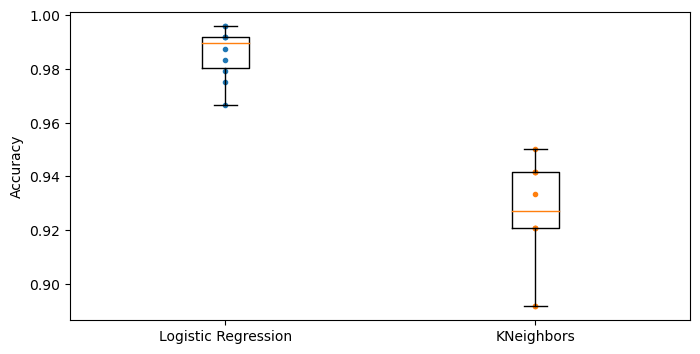

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*10, log_score, ".")
plt.plot([2]*10, knn_score, ".")
plt.boxplot([log_score, knn_score], labels=("Logistic Regression", "KNeighbors"))
plt.ylabel("Accuracy")
plt.show()

As we can see, the **Logistic Regression** model has a better performance than the **KNeighbors Classifier**

In [36]:
X_test_transformed = preprocess_pipeline.transform(X_test)

## Fine-Tune The Logistic Regression Model

In [37]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_distribs = {
    'C' : uniform(loc=0, scale=4)
}

random_search = RandomizedSearchCV(log_clf, param_distribs, n_iter=10, cv=5, random_state=42)
random_search.fit(X_train_transformed, y_train)

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=1000, random_state=42),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000018044DBFCD0>},
                   random_state=42)

In [38]:
random_search.best_params_

{'C': 1.49816047538945}

In [39]:
random_search.best_score_

0.9870833333333333

## Accuracy

In [40]:
random_search.best_estimator_.fit(X_train_transformed, y_train)
tuned_accuracy = random_search.score(X_test_transformed, y_test)
tuned_accuracy

0.99

## Precision / Recall

In [41]:
from sklearn.metrics import precision_score, recall_score

log_clf = random_search.best_estimator_
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print(f"Precision: {precision_score(y_test, y_pred):.2%}")
print(f"Recall: {recall_score(y_test, y_pred):.2%}")

Precision: 95.88%
Recall: 97.89%


## Save the final model

In [42]:
import joblib

joblib.dump(random_search.best_estimator_, "spam_email_classification.pkl")

['spam_email_classification.pkl']

## Deploy the model

In [60]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

final_model_reloaded = joblib.load("spam_email_classification.pkl")

new_data = X_train_transformed[:50]  # pretend these are new data
predictions = final_model_reloaded.predict(new_data)

In [61]:
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0])

In [62]:
# Examples
X_examples = X_train[:50]
X_examples_wordcounts = EmailToWordCounterTransformer().fit_transform(X_examples)
X_examples_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'url': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 'remsburg': 1, 'letter': 1, 'william': 1, 'short': 1, 'again': 1, 'becom